<a href="https://colab.research.google.com/github/projectsvy67/NST_Implementation/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image

import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Loading and transforming the content image and style image
import numpy as np
image_size = 512 if torch.cuda.is_available() else 224
content_image = "/content/il_1080xN.4424885976_elcl.webp"
style_image = "/content/original-oil-painting-beautifl-spring-260nw-1996821224 (1).webp"
def load_and_transform_image(image_name):
  image = Image.open(image_name)
  image_transform = transforms.Compose([transforms.Resize((image_size,image_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  image = image_transform(image)
  return image

content=load_and_transform_image(content_image).to(device)
style=load_and_transform_image(style_image).to(device)

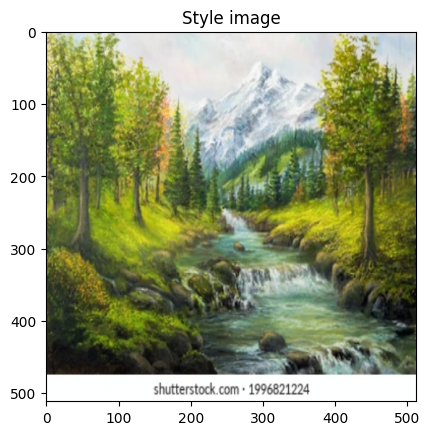

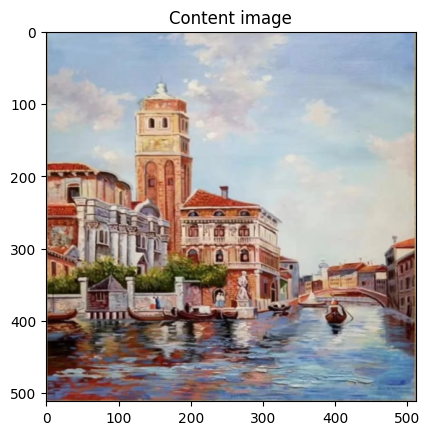

In [ ]:
# Writing a function to show the image given in tensor format
import numpy as np
def image_show(image_in_tensor):
  # Doing de-normalization
  std_dev = (0.229, 0.224, 0.225)
  mean =(0.485, 0.456, 0.406)
  image = image_in_tensor.to("cpu").clone().detach()
  image = np.array(image)
  image = image.transpose(1,2,0)
  image = image*std_dev + mean
  image = image.clip(0,1) # To ensure that all pixel values are between 0 and 1
  return image

plt.imshow(image_show(style))
plt.title("Style image")
plt.show()
plt.imshow(image_show(content))
plt.title("Content image")
plt.show()

In [ ]:
# Defining the loss functions

#1. Defining the content loss
def get_content_loss(target_image, content_image):
  return torch.mean((target_image-content_image)**2)

# Defining the gram_matrix
def get_gram_matrix(tensor):
    c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram_matrix = torch.mm(tensor, tensor.t())
    return gram_matrix
#2. Defining the style loss
def get_style_loss(target_image,style_image):
  c,h,w = target_image.size()
  gram_target = get_gram_matrix(target_image)
  gram_style = get_gram_matrix(style_image)
  return torch.mean((gram_target - gram_style) ** 2)/(c*h*w)

In [ ]:
# Import the VGG19 model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ['0', '5', '10', '19', '28']
        self.model = models.vgg19(weights=True).features[:29]

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

# Instantiate the model
model = VGG().to(device).eval()

# Freeze the model parameters to avoid updation of model parameeters during the training
for parameter in model.parameters():
    parameter.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 177MB/s]


Step 0, Total Loss: 16483.765625
Step 50, Total Loss: 4546.2880859375


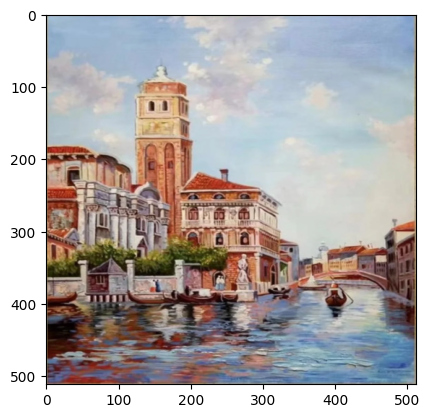

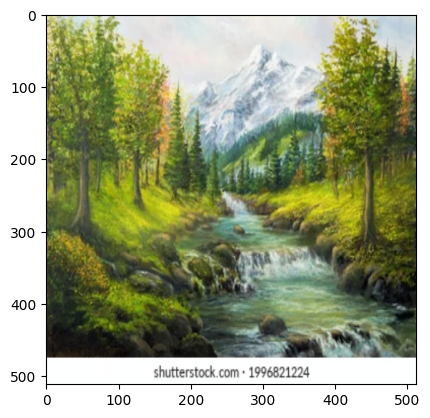

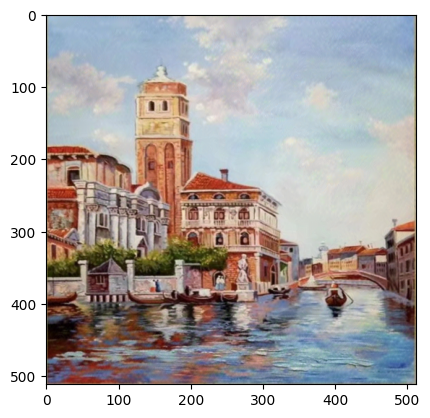

In [ ]:
# Define the parameters for loss function i.e alpha and beta
alpha = 5
beta = 20

# Create a target image(copy of the content image)
target_image = content.clone().requires_grad_(True).to(device)

# Define the hyperparameter
optimizer = optim.Adam([target_image], lr = 0.001)
# Define the number of epochs and display interval
epochs = 100
display_every = 50
for e in range(epochs):
    target_features = model(target_image)
    content_features = model(content)
    style_features = model(style)

    content_loss = get_content_loss(target_features[1], content_features[1])

    style_loss = 0
    for target_feat, style_feat in zip(target_features, style_features):
        style_loss += get_style_loss(target_feat, style_feat)

    total_loss = alpha * content_loss + beta * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if e % display_every == 0:
        print(f'Step {e}, Total Loss: {total_loss.item()}')

# Showing the final result
final_img = image_show(target_image)
plt.imshow(image_show(style))
plt.title("Style image")
plt.show()
plt.imshow(image_show(content))
plt.title("Content image")
plt.show()
plt.imshow(image_show(final_img))
plt.title("Generated image")
plt.show()


In [ ]:
# Saving the model